# Playground to understand how to run 3D Kirchoff mig of Volve data

**Author: M.Ravasi**

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import segyio

from scipy.interpolate import RegularGridInterpolator
from pylops.waveeqprocessing.kirchhoff import Kirchhoff
from segyshot import SegyShot
from visual import explode_volume


## Parameters

In [2]:
# Geometry
#ishotin, ishotend = 5500, 5540 # supersmall
ishotin, ishotend = 5370, 5670 # 2d line
#ishotin, ishotend = 2880, 6715 # small
#ishotin, ishotend = 2880, 9596 # large

ivxmax = 22 # small
#ivxmax = 35 # large

## Data loading

In [3]:
velfilepath = '/home/ravasim/Data/Volve/ST10010ZC11-MIG-VEL.MIG_VEL.VELOCITY.3D.JS-017527.segy'
filepath = '/home/ravasim/Data/Volve/'

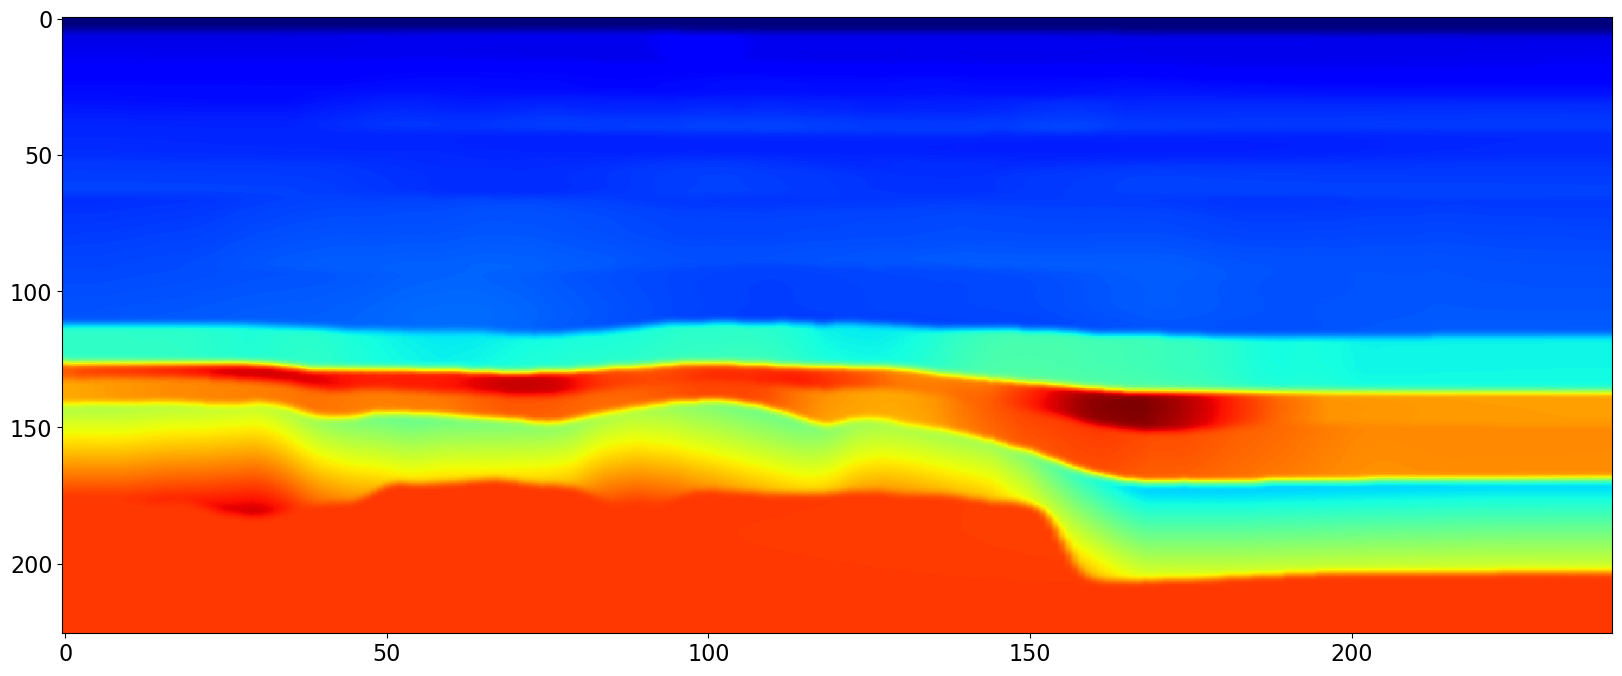

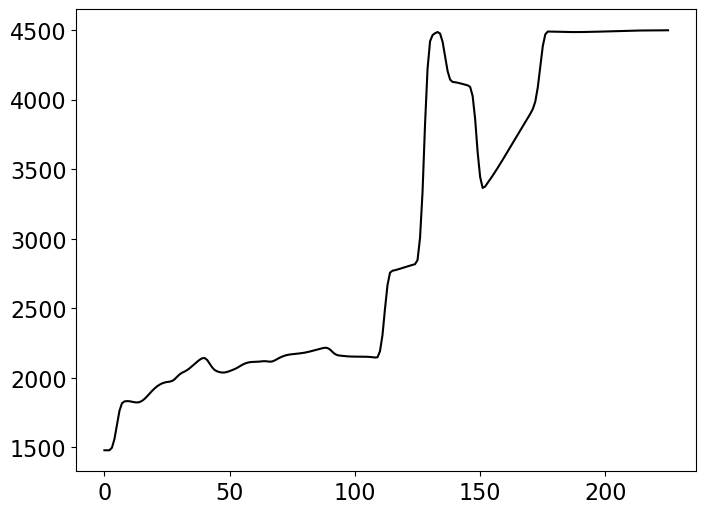

In [4]:
fvmod = segyio.open(velfilepath)
vmod = segyio.cube(velfilepath)
ilvel, xlvel, zvel = fvmod.ilines, fvmod.xlines, fvmod.samples

ilsvel, xlsvel = fvmod.attributes(segyio.TraceField.INLINE_3D)[:], fvmod.attributes(segyio.TraceField.CROSSLINE_3D)[:]

scvel = fvmod.header[0][segyio.TraceField.SourceGroupScalar]
if (scvel<0):
    scvel=1./abs(scvel)
xvel, yvel = scvel * fvmod.attributes(segyio.TraceField.CDP_X)[:] , scvel * fvmod.attributes(segyio.TraceField.CDP_Y)[:]

plt.figure(figsize=(20, 8))
plt.imshow(vmod[50].T, cmap='jet')
plt.axis('tight');

plt.figure()
plt.plot(vmod[50, 120], 'k');

In [5]:
inputfile = os.path.join(filepath, 'ST10010_1150780_40203.sgy')
f = segyio.open(inputfile, ignore_geometry=True)

## Data and velocity model cropping for imaging

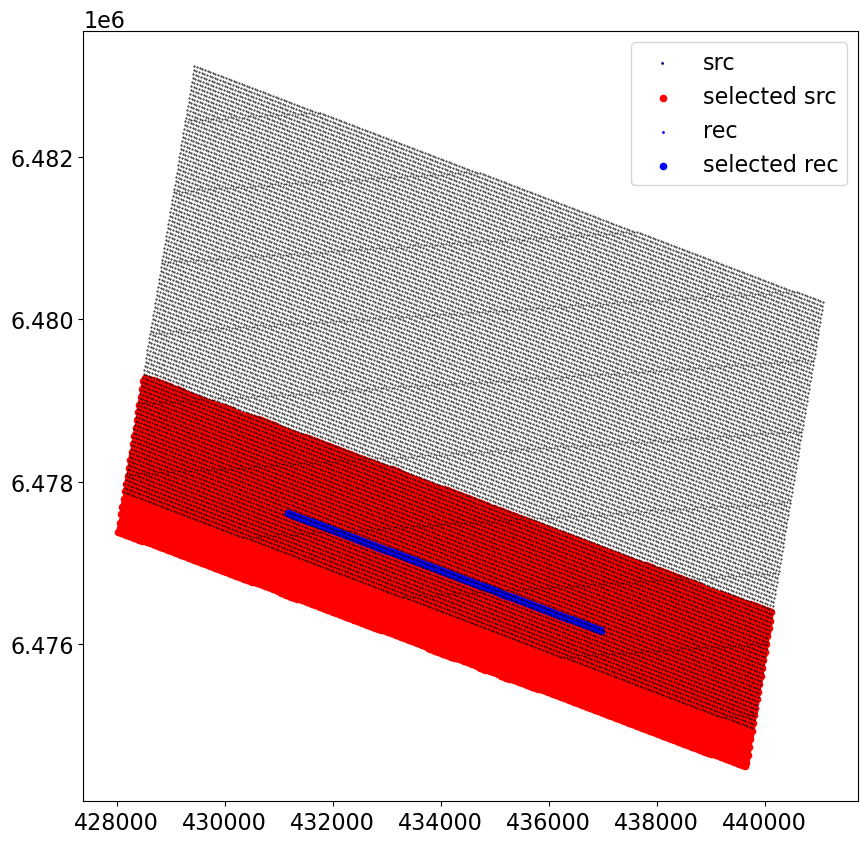

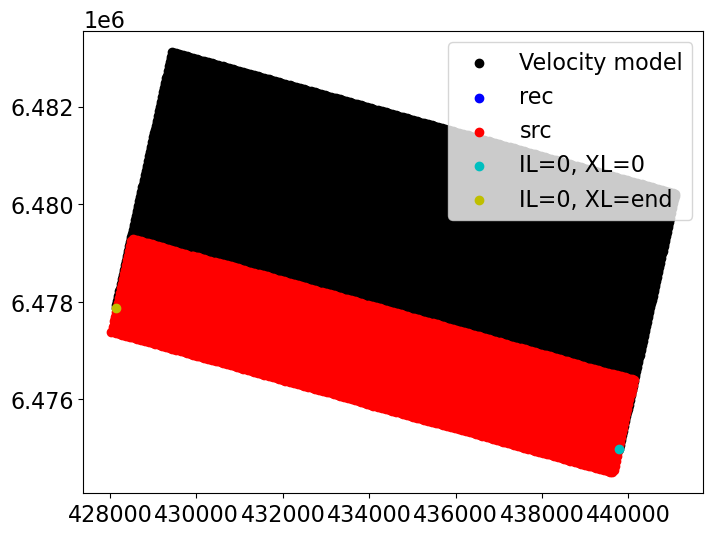

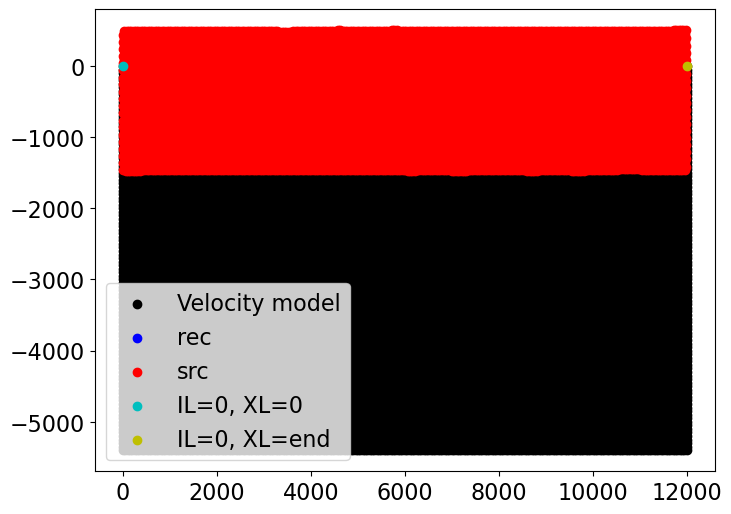

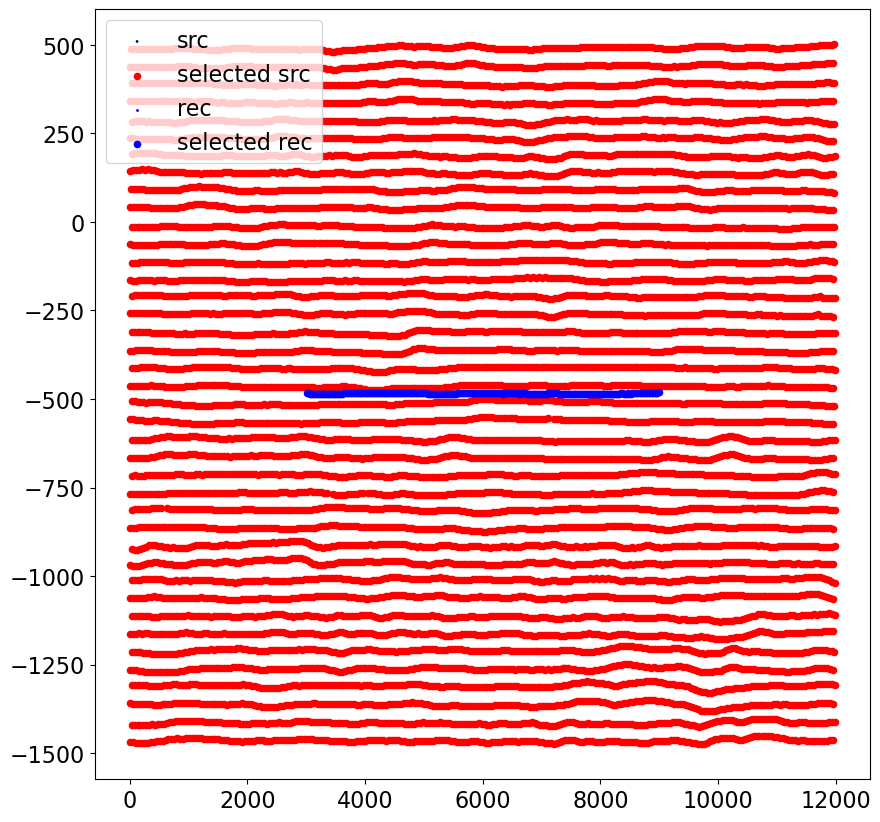

In [6]:
sg = SegyShot(inputfile, components=['P', 'VZ', 'VX', 'VY'])
sg.interpret()
sg.showgeometry()
plt.scatter(xvel, yvel, c='k', s=.2)

_,_,_,_, (xvel_local, yvel_local) = \
    sg.rotategeometry(velfile=velfilepath, plotflag=1)
sg.showgeometry(local=True)

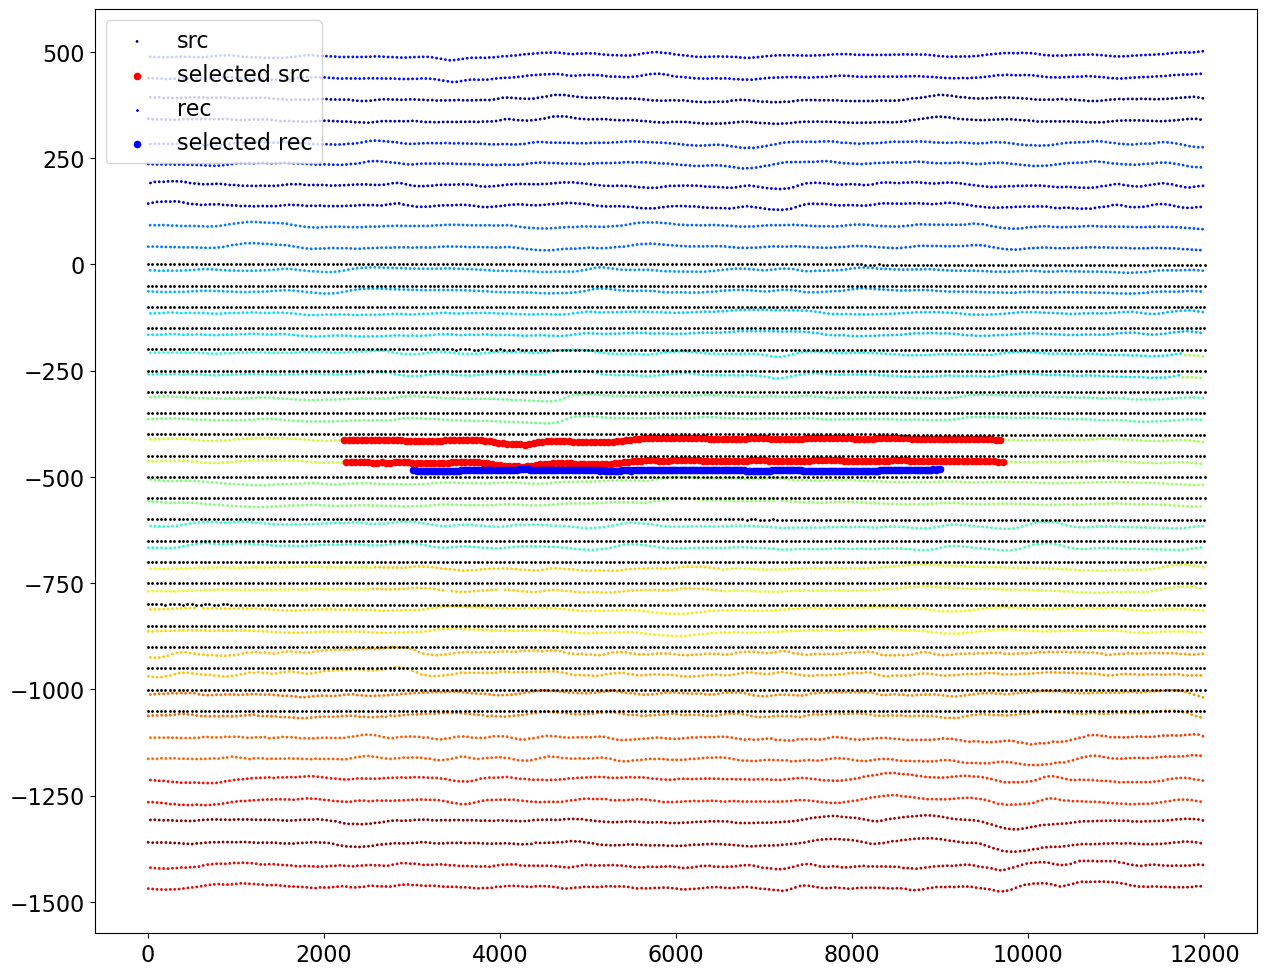

In [7]:
sg.resetsrcs()
sg.selectsrcs(ishotin, ishotend, plotflag=False)
sg.showgeometry(local=True, figsize=(15, 12))

# Extract only useful part of velocity model
xvel_localgrid = xvel_local.reshape(vmod.shape[:2])[:ivxmax]
yvel_localgrid = yvel_local.reshape(vmod.shape[:2])[:ivxmax]
vel_local = vmod[:ivxmax]

plt.scatter(xvel_localgrid.ravel(), yvel_localgrid.ravel(), c='k', s=1);
# plt.scatter(xvel_localgrid.ravel(), yvel_localgrid.ravel(), c=vel_local[:, :, 150].ravel(), s=7, cmap='jet')

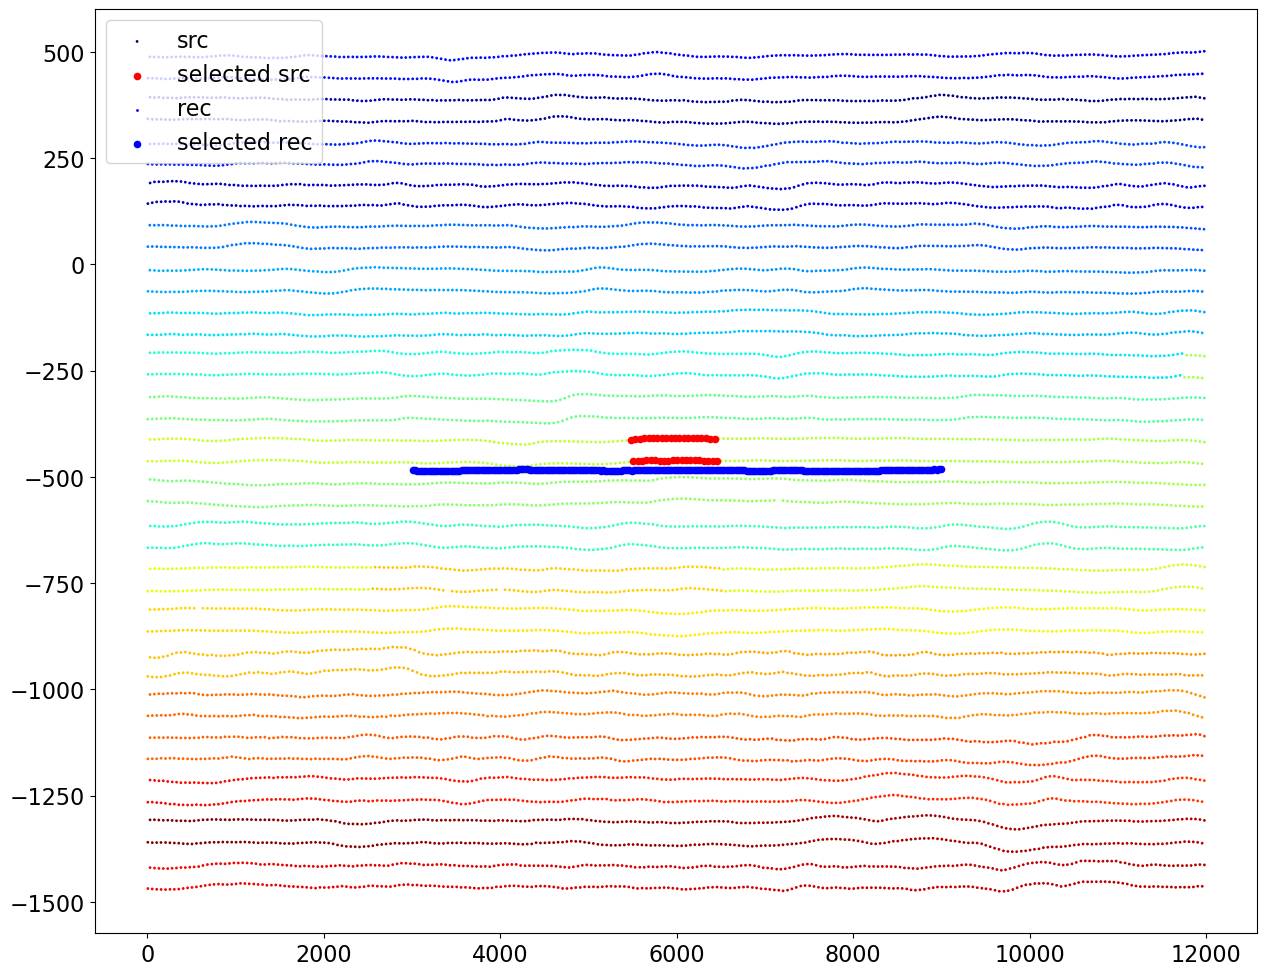

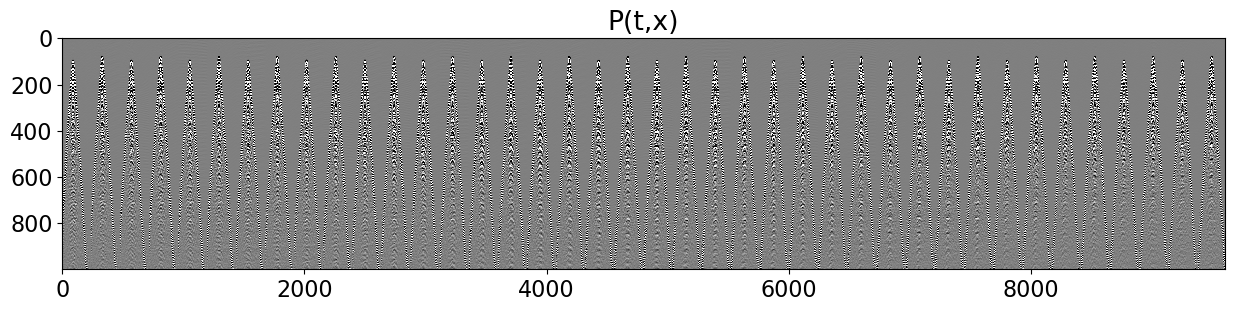

In [8]:
sg.resetsrcs()
sg.selectsrcs(5500, 5540, plotflag=False)
sg.showgeometry(local=True, figsize=(15, 12))
sg.resetsrcs()

shots = np.concatenate([sg.get_shotgather(ishot)['P'][np.newaxis, :, :1000] for ishot in range(3560, 3600)])

fig, ax = plt.subplots(1, 1, figsize=(15, 3))
ax.imshow(shots.reshape(shots.shape[0]*shots.shape[1], -1).T, cmap='gray', vmin=-1e5, vmax=1e5)
ax.set_title('P(t,x)')
ax.axis('tight');

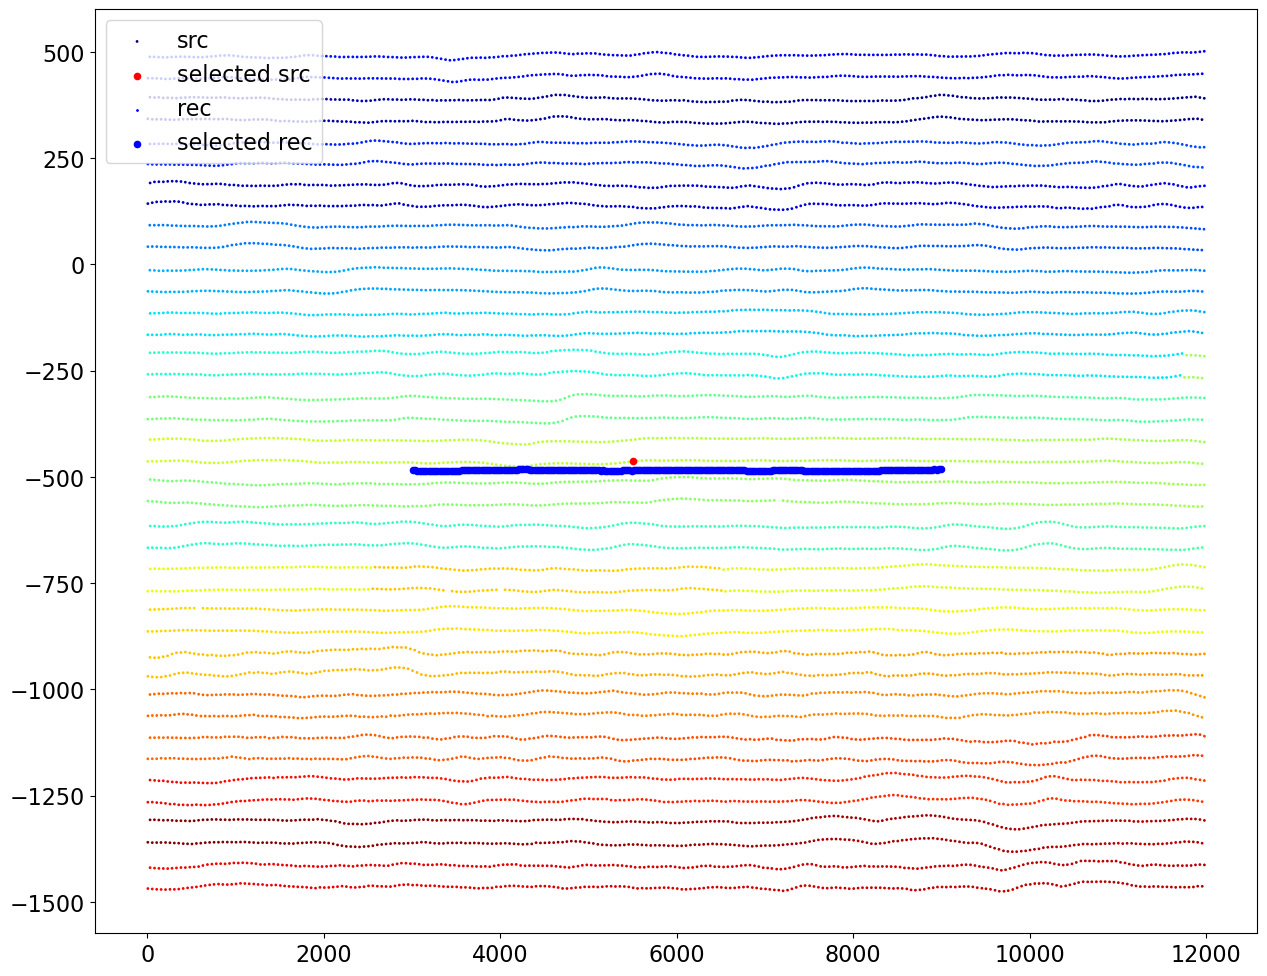

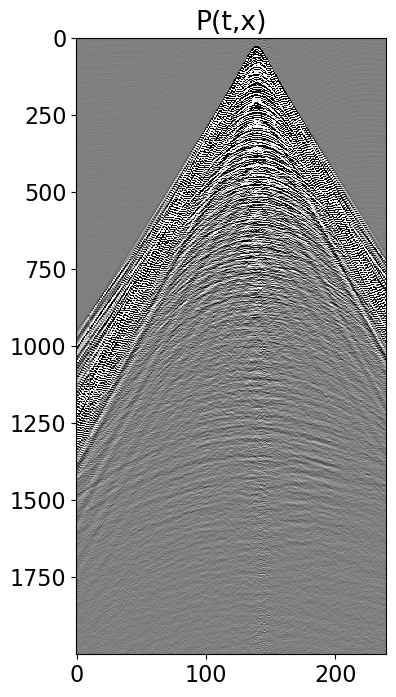

In [9]:
sg.resetsrcs()
sg.selectsrcs(5538, 5538+1, plotflag=False)
sg.showgeometry(local=True, figsize=(15, 12))

shot = sg.get_shotgather(5538)

fig, ax = plt.subplots(1, 1, figsize=(4, 8))
ax.imshow(shot['P'][:, :2000].T, cmap='gray', vmin=-1e5, vmax=1e5)
ax.set_title('P(t,x)')
ax.axis('tight');

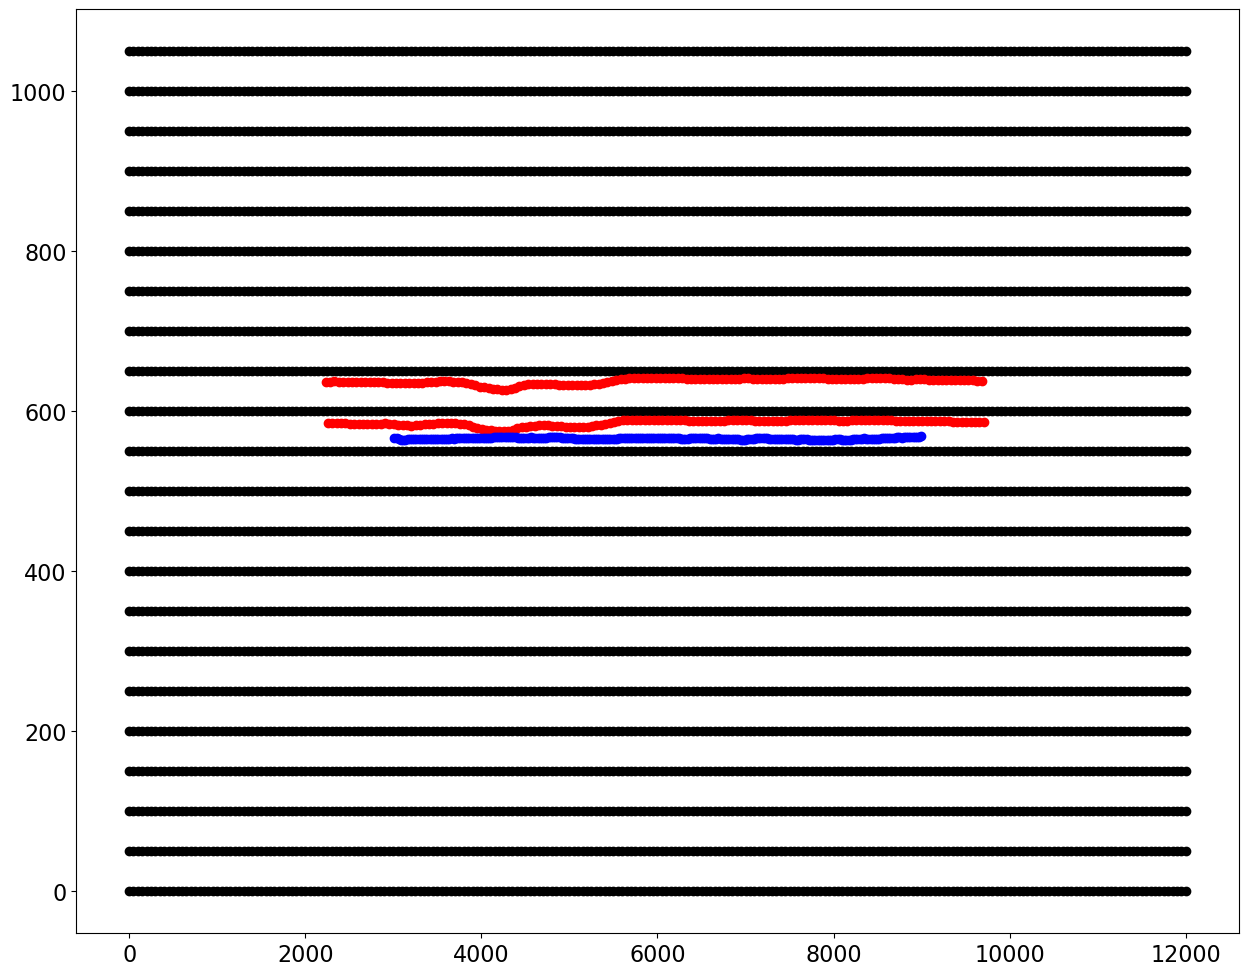

In [10]:
# Local grid
nx, ny = xvel_localgrid.T.shape
nz = len(zvel)
x0 = xvel_localgrid.min()
y0 = yvel_localgrid.min()

dx = np.round(np.mean(np.abs(np.diff(xvel_localgrid[0]))))
dy = np.round(np.mean(np.abs(np.diff(yvel_localgrid[:, 0]))))

xvel_local = np.arange(nx) * dx
yvel_local = np.arange(ny) * dy

xvel_localgrid, yvel_localgrid = np.meshgrid(xvel_local, yvel_local, indexing='ij')

sg.resetsrcs()
sg.selectsrcs(ishotin, ishotend, plotflag=False)

srcx_local = sg.srcx_local[sg.selected_src] - x0
srcy_local = sg.srcy_local[sg.selected_src] - y0
srcz_local = sg.srcz[sg.selected_src]

recx_local = sg.recx_local - x0
recy_local = sg.recy_local - y0
recz_local = sg.recz

ns, nr = srcx_local.size, recx_local.size

plt.figure(figsize=(15, 12))
plt.scatter(xvel_localgrid.ravel(), yvel_localgrid.ravel(), color='k')
plt.scatter(srcx_local, srcy_local, color='r')
plt.scatter(recx_local, recy_local, color='b');

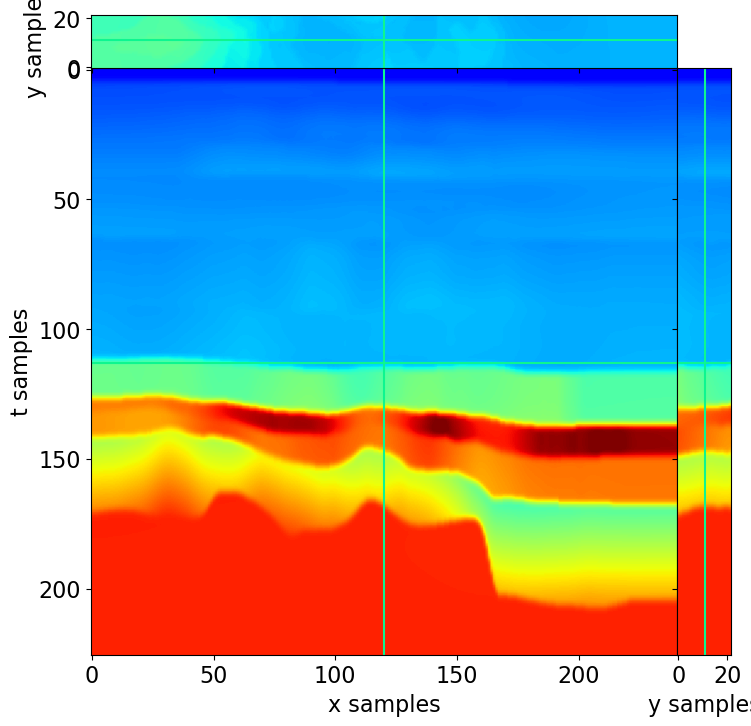

In [11]:
explode_volume(vel_local.transpose(2, 1, 0), cmap='jet', clipval=(1000, 5000));

## 2D Kirchooff

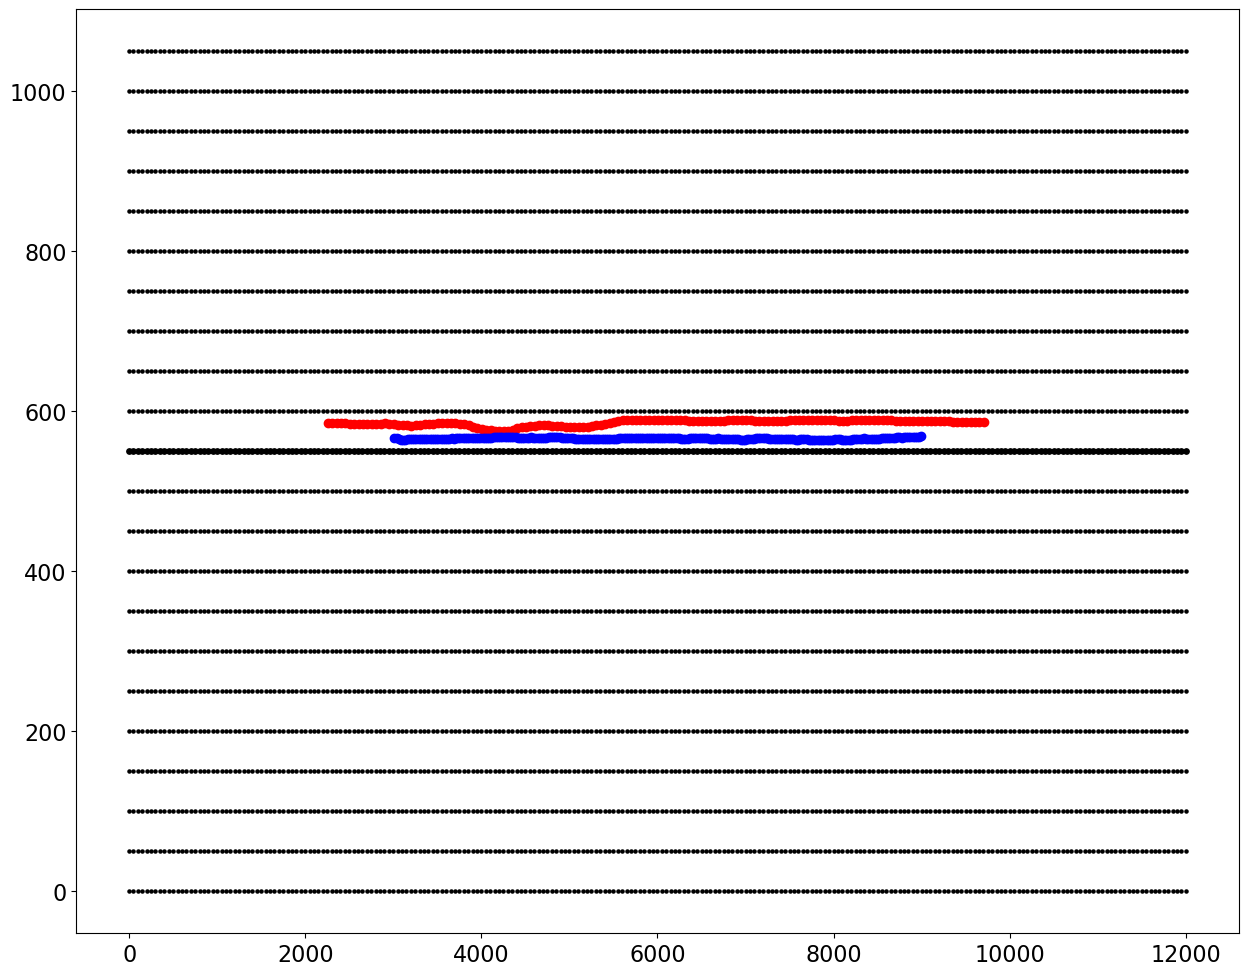

In [12]:
# 2D Local grid
iyvel = 11

vel_2d = vel_local[iyvel]
sg.resetsrcs()
sg.selectsrcs(ishotin, ishotend, jump=2, plotflag=False)

srcx_local = sg.srcx_local[sg.selected_src] - x0
srcy_local = sg.srcy_local[sg.selected_src] - y0
srcz_local = sg.srcz[sg.selected_src]

recx_local = sg.recx_local - x0
recy_local = sg.recy_local - y0
recz_local = sg.recz

src_local = np.vstack([srcx_local, srcz_local])
rec_local = np.vstack([recx_local, recz_local])

ns, nr = srcx_local.size, recx_local.size

plt.figure(figsize=(15, 12))
plt.scatter(xvel_localgrid.ravel(), yvel_localgrid.ravel(), color='k', s=5)
plt.scatter(xvel_localgrid[:, iyvel].ravel(), yvel_localgrid[:, iyvel].ravel(), color='k', s=15)
plt.scatter(srcx_local, srcy_local, color='r')
plt.scatter(recx_local, recy_local, color='b');

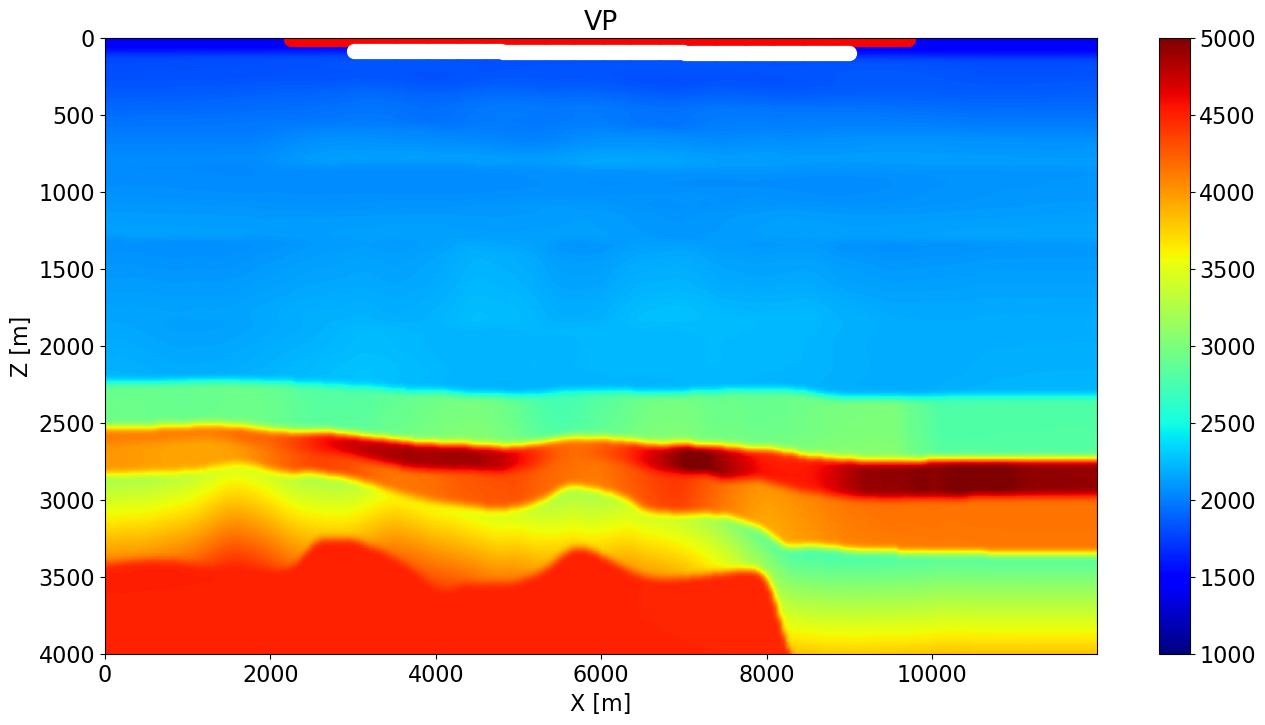

In [13]:
# Interpolate velocity model
dx2d, dz2d = 10, 10
nz2d, nx2d = int(zvel[-1]//dz2d), int(xvel_local[-1]//dx2d)

zvel_local2d = np.arange(nz2d) * dz2d
xvel_local2d = np.arange(nx2d) * dx2d

X2d, Z2d = np.meshgrid(xvel_local2d, zvel_local2d, indexing='ij')
XZ2d = np.vstack((X2d.ravel(), Z2d.ravel())).T

interpolator = RegularGridInterpolator((xvel_local, zvel), vel_2d, bounds_error=False, fill_value=0)
vel_2dinterp = interpolator(XZ2d).reshape(nx2d, nz2d)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))
im = ax.imshow(vel_2dinterp.T, cmap='jet', vmin=1000, vmax=5000, extent=(xvel_local2d[0], xvel_local2d[-1], zvel_local2d[-1], zvel_local2d[0]))
ax.plot(src_local[0], src_local[1], '.r', ms=20)
ax.plot(rec_local[0], rec_local[1], '.w', ms=20)
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'VP')
ax.axis('tight')
ax.set_ylim(4000, 0)
plt.colorbar(im)

In [14]:
trav_srcs_eik, trav_recs_eik, _, _, _, _ = \
    Kirchhoff._traveltime_table(zvel_local2d, xvel_local2d, src_local, rec_local,
                                vel_2dinterp, mode='eikonal')

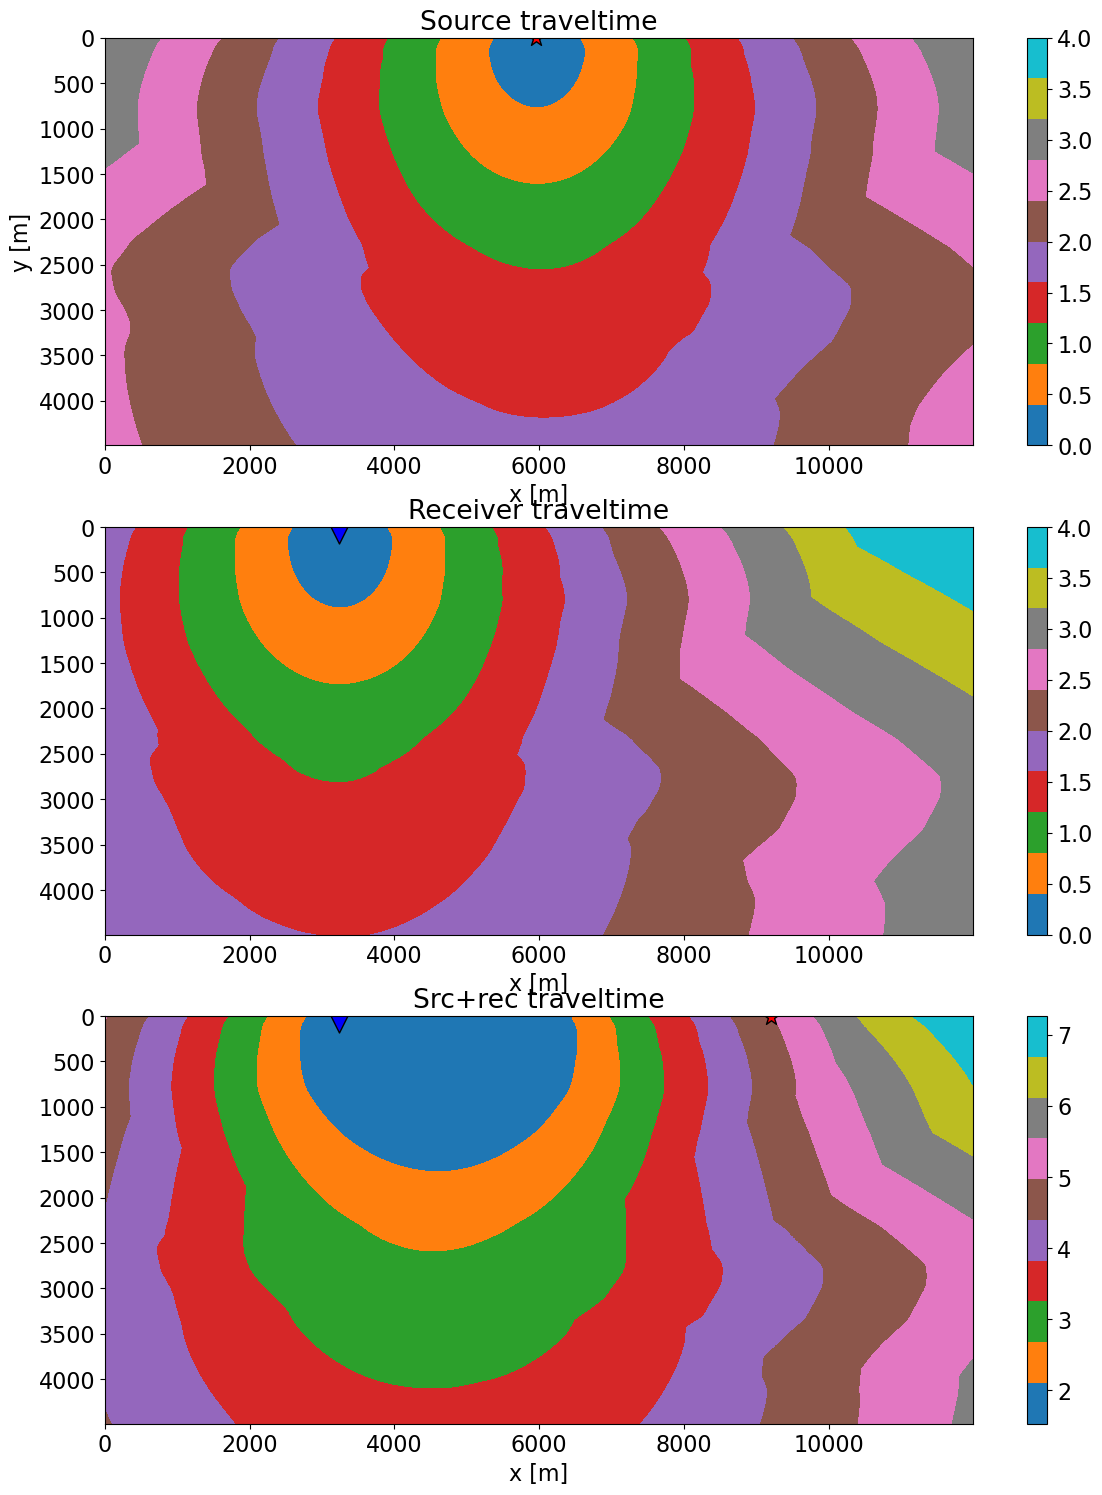

In [15]:
fig, axs = plt.subplots(3, 1, sharey=True, figsize=(14, 18))
im = axs[0].imshow(trav_srcs_eik[:, ns//2].reshape((nx2d, nz2d)).T, cmap='tab10', vmin=0, vmax=4,
                   extent = (xvel_local2d[0], xvel_local2d[-1], zvel_local2d[-1], zvel_local2d[0]))
axs[0].scatter(srcx_local[ns//2], srcz_local[ns//2], marker='*', s=150, c='r', edgecolors='k')
axs[0].axis('tight')
axs[0].set_xlabel('x [m]')
axs[0].set_ylabel('y [m]')
axs[0].set_title('Source traveltime')
plt.colorbar(im, ax=axs[0])
im = axs[1].imshow(trav_recs_eik[:, -10].reshape((nx2d, nz2d)).T, cmap='tab10', vmin=0, vmax=4,
                   extent = (xvel_local2d[0], xvel_local2d[-1], zvel_local2d[-1], zvel_local2d[0]))
axs[1].scatter(recx_local[-10], recz_local[-10], marker='v', s=150, c='b', edgecolors='k')
axs[1].axis('tight')
axs[1].set_xlabel('x [m]')
axs[1].set_title('Receiver traveltime')
plt.colorbar(im, ax=axs[1])
im = axs[2].imshow(trav_srcs_eik[:, ns//2].reshape((nx2d, nz2d)).T + 
                   trav_recs_eik[:, -10].reshape((nx2d, nz2d)).T, cmap='tab10', 
                   extent = (xvel_local2d[0], xvel_local2d[-1], zvel_local2d[-1], zvel_local2d[0]))
axs[2].scatter(srcx_local[10], srcz_local[10], marker='*', s=150, c='r', edgecolors='k')
axs[2].scatter(recx_local[-10], recz_local[-10], marker='v', s=150, c='b', edgecolors='k')
axs[2].axis('tight')
axs[2].set_xlabel('x [m]')
axs[2].set_title('Src+rec traveltime')
plt.colorbar(im, ax=axs[2]);

(0.0, 36000.0, 3.998, 0.0)

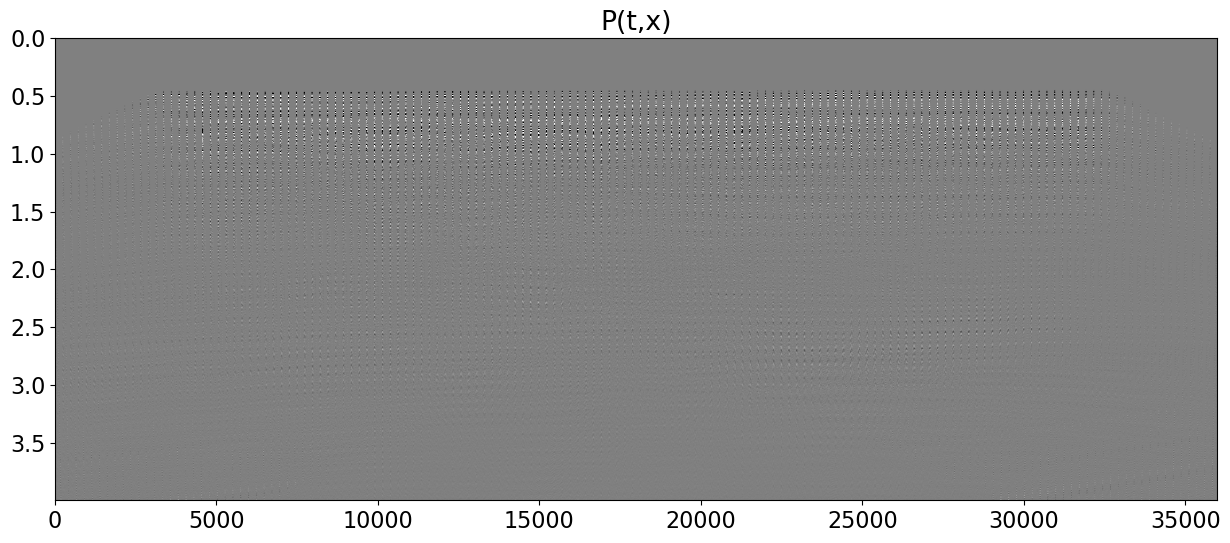

In [16]:
# Extract data and remove direct arrival
itmax = 2000
vwater = 1500
t = sg.t[:itmax]
dt = t[1]
wav, wavc = np.zeros(81), 41
wav[wavc] = 1.

data = []
for iishot, ishot in enumerate(sg.selected_src):
    d = sg.get_shotgather(ishot)['P'][:, :itmax]
    direct = np.sqrt(np.sum((src_local[:, iishot:iishot+1]-rec_local)**2, axis=0)) / vwater
    for irec in range(nr):
        d[irec, :int(direct[irec]/dt+200)] = 0
    data.append(d[np.newaxis])
data = np.concatenate(data)

fig, ax = plt.subplots(1, 1, figsize=(15, 6))
ax.imshow(data.reshape(data.shape[0] * data.shape[1], -1).T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(0, data.shape[0] * data.shape[1], t[-1], 0))
ax.set_title('P(t,x)')
ax.axis('tight')

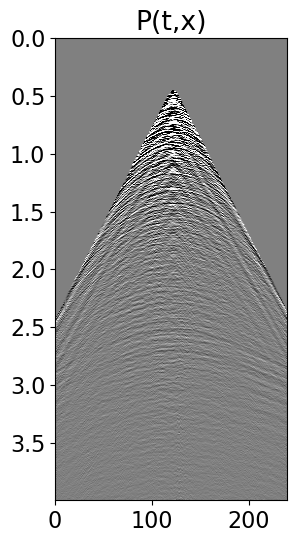

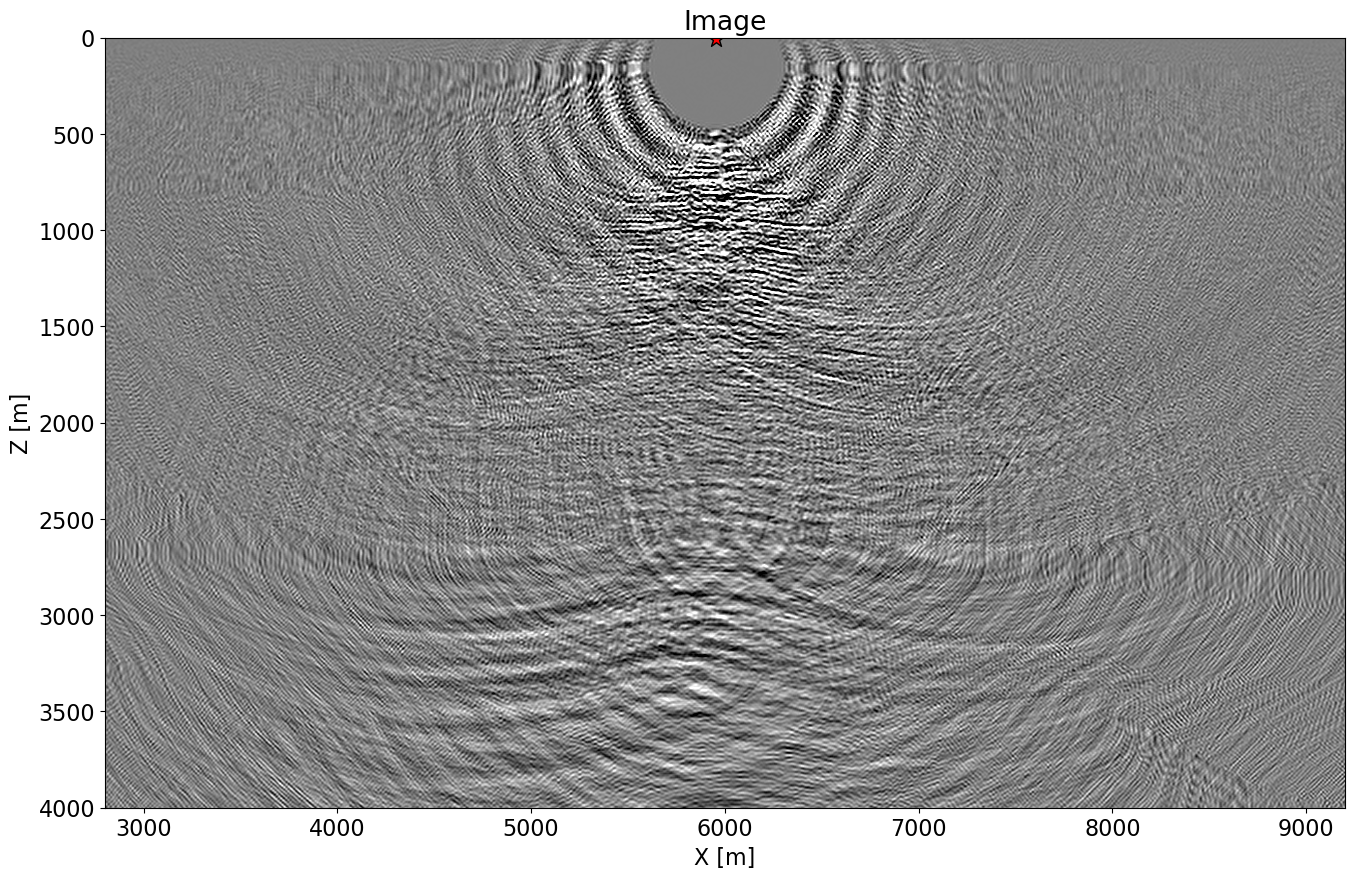

In [17]:
# One shot
KOp = Kirchhoff(zvel_local2d, xvel_local2d, t, src_local[:, ns//2:ns//2+1], rec_local, vel_2dinterp,
                wav, wavc, dynamic=False, trav=(trav_srcs_eik[:, ns//2:ns//2+1], trav_recs_eik),
                mode='byot', engine='numba')

fig, ax = plt.subplots(1, 1, figsize=(3, 6))
ax.imshow(data[ns//2].T, cmap='gray', vmin=-1e5, vmax=1e5, extent=(0,  data.shape[1], t[-1], 0))
ax.set_title('P(t,x)')
ax.axis('tight')

image = KOp.H * data[ns//2:ns//2+1]
image = image.reshape(nx2d, nz2d)

clip = 1e8
gain = np.sqrt(zvel_local2d)

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.imshow(image.T * gain[:, np.newaxis], cmap='gray', vmin=-clip, vmax=clip, 
          interpolation='sinc', extent=(xvel_local2d[0], xvel_local2d[-1], zvel_local2d[-1], zvel_local2d[0]))
ax.scatter(srcx_local[ns//2], srcz_local[ns//2], marker='*', s=150, c='r', edgecolors='k')
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'Image')
ax.axis('tight')
ax.set_xlim(2800, 9200)
ax.set_ylim(4000, 0);

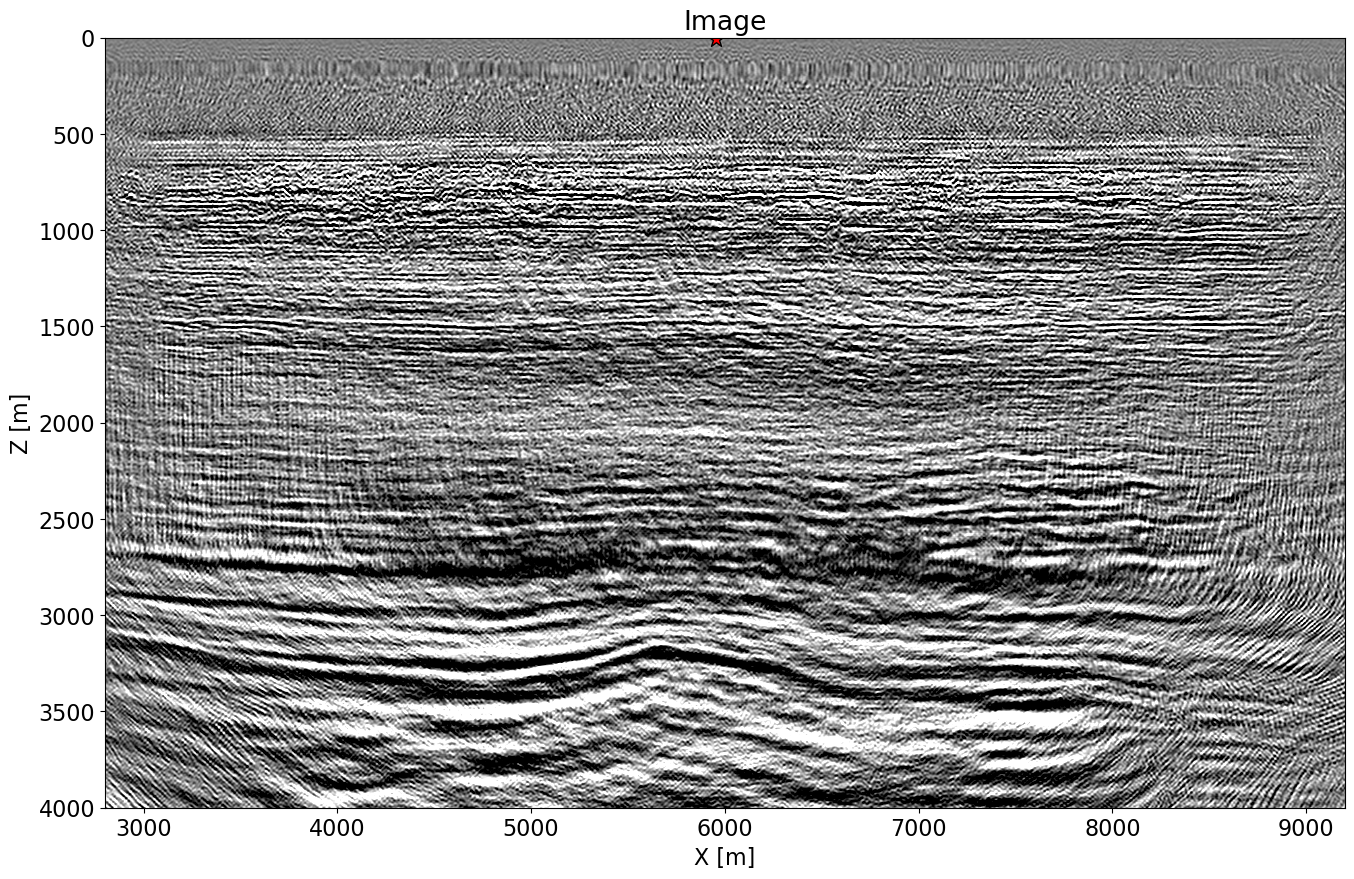

In [18]:
# All shots
KOp = Kirchhoff(zvel_local2d, xvel_local2d, t, src_local, rec_local, vel_2dinterp,
                wav, wavc, dynamic=False, trav=(trav_srcs_eik, trav_recs_eik),
                mode='byot', engine='numba')

image = KOp.H * data
image = image.reshape(nx2d, nz2d)

clip = 1e9
gain = np.sqrt(zvel_local2d)

fig, ax = plt.subplots(1, 1, figsize=(16, 10))
ax.imshow(image.T * gain[:, np.newaxis], cmap='gray', vmin=-clip, vmax=clip, 
          interpolation='sinc', extent=(xvel_local2d[0], xvel_local2d[-1], zvel_local2d[-1], zvel_local2d[0]))
ax.scatter(srcx_local[ns//2], srcz_local[ns//2], marker='*', s=150, c='r', edgecolors='k')
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'Image')
ax.axis('tight')
ax.set_xlim(2800, 9200)
ax.set_ylim(4000, 0);

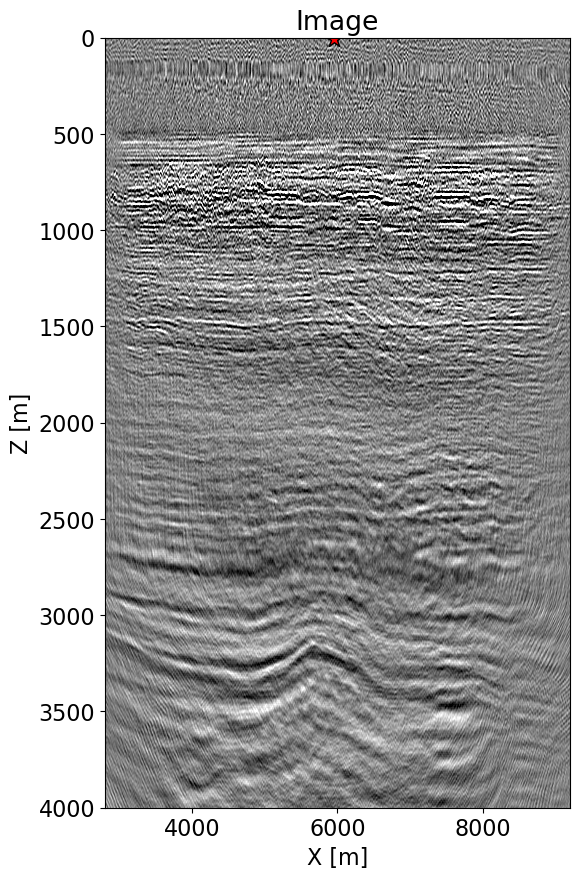

In [19]:
clip = 5e7
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
ax.imshow(image.T , cmap='gray', vmin=-clip, vmax=clip, 
          interpolation='sinc', extent=(xvel_local2d[0], xvel_local2d[-1], zvel_local2d[-1], zvel_local2d[0]))
ax.scatter(srcx_local[ns//2], srcz_local[ns//2], marker='*', s=150, c='r', edgecolors='k')
ax.set_xlabel(r'X [m]')
ax.set_ylabel(r'Z [m]')
ax.set_title(r'Image')
ax.axis('tight')
ax.set_xlim(2800, 9200)
ax.set_ylim(4000, 0);